# Surface normals

Author(s): Jukka Aho

**Abstract**: Testing different strategies to calculate surface normals. These are important when calculating mortar projections.

In [1]:
using JuliaFEM

In [2]:
using PyPlot

In [3]:
phi = linspace(pi, 0, 4)
nelements = length(phi)-1
nnodes = length(phi)
elements = []
R = 10.0
for i=1:nelements
    con = [i, mod(i, nnodes)+1]
    seg = JuliaFEM.PSeg(con)
    # create vector field :geometry for elements
    pnts = Vector[]
    for deg in phi[con]
        X = R*[cos(deg), sin(deg)]
        push!(pnts, X)
    end
    JuliaFEM.set_field(seg, :geometry, pnts)
    push!(elements, seg)
end
elements

3-element Array{Any,1}:
 JuliaFEM.PSeg([1,2],Dict{Any,Any}(:geometry=>Array{T,1}[[-10.0,1.2246467991473533e-15],[-4.999999999999998,8.660254037844387]]),1)       
 JuliaFEM.PSeg([2,3],Dict{Any,Any}(:geometry=>Array{T,1}[[-4.999999999999998,8.660254037844387],[5.000000000000001,8.660254037844386]]),1)
 JuliaFEM.PSeg([3,4],Dict{Any,Any}(:geometry=>Array{T,1}[[5.000000000000001,8.660254037844386],[10.0,0.0]]),1)                            

In [4]:
# calculate "local" normals in elements, in a way that
# n = Nᵢnᵢ gives some reasonable results for ξ ∈ [-1, 1]

for el in elements
    nfld = Vector[]
    for xi in Vector[[-1.0], [1.0]]
        t = JuliaFEM.dinterpolate(el, :geometry, xi)
        n = [0 -1; 1 0]*t
        n /= norm(n)
        push!(nfld, n)
    end
    JuliaFEM.set_field(el, :normals, nfld)
end
elements

3-element Array{Any,1}:
 JuliaFEM.PSeg([1,2],Dict{Any,Any}(:geometry=>Array{T,1}[[-10.0,1.2246467991473533e-15],[-4.999999999999998,8.660254037844387]],:normals=>Array{T,1}[[-0.8660254037844386,0.5000000000000002],[-0.8660254037844386,0.5000000000000002]]),1)
 JuliaFEM.PSeg([2,3],Dict{Any,Any}(:geometry=>Array{T,1}[[-4.999999999999998,8.660254037844387],[5.000000000000001,8.660254037844386]],:normals=>Array{T,1}[[1.7763568394002506e-16,1.0],[1.7763568394002506e-16,1.0]]),1)                 
 JuliaFEM.PSeg([3,4],Dict{Any,Any}(:geometry=>Array{T,1}[[5.000000000000001,8.660254037844386],[10.0,0.0]],:normals=>Array{T,1}[[0.8660254037844387,0.5],[0.8660254037844387,0.5]]),1)                                                     

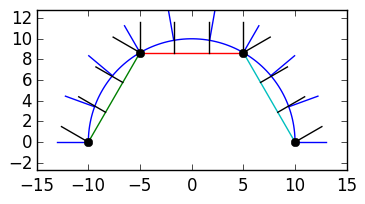

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2f887e5090>

In [5]:
function plot_stuff(elements)
    phi2 = linspace(0, pi, 100)
    phi3 = linspace(0, pi, 10)
    phi4 = linspace(0, pi, 4)
    figure(figsize=(4, 2))
    plot(R*cos(phi2), R*sin(phi2))
    for fi in phi3
        p0 = R*[cos(fi), sin(fi)]
        p1 = (R+3)*[cos(fi), sin(fi)]
        plot([p0[1], p1[1]], [p0[2], p1[2]], "-b")
    end
    axis("equal")
    xlim(-1.5*R, 1.5*R)
    ylim(-0.5*R, 1.5*R)
    # create a array of vectors
    xis = Vector[[xi] for xi in linspace(-1, 1, 4)]
    for el in elements
        coords = JuliaFEM.interpolate(el, :geometry, xis)
        # extract 1 and 2 components from array of coordinates
        xs = [X[1] for X in coords]
        ys = [X[2] for X in coords]
        plot(xs, ys, "-")
        normals = JuliaFEM.interpolate(el, :normals, xis)
        for i=1:length(normals)
            p0 = coords[i]
            p1 = coords[i] + normals[i]*3
            plot([p0[1], p1[1]], [p0[2], p1[2]], "-k")
        end
    end
    plot(R*cos(phi4), R*sin(phi4), "ko")
end

plot_stuff(elements)

Blue lines "accurate" normal direction, other lines are approximations.

**Strategy 1**: average normals of adjacent elements in common nodes, maybe by weighting it with areas / lenghts ...

In [6]:
using JuliaFEM: get_connectivity, get_field, set_field
get_connectivity(elements[1])

2-element Array{Int64,1}:
 1
 2

In [7]:
function average_normals(elements, normal_field=:normals)
    d = Dict()
    for el in elements
        c = get_connectivity(el)
        n = get_field(el, normal_field)
        for (ci, ni) in zip(c, n)
            d[ci] = haskey(d, ci) ? d[ci] + ni : ni
        end
    end
    for (ci, ni) in d
        d[ci] /= norm(d[ci])
    end
    for el in elements
        c = get_connectivity(el)
        new_normals = [d[ci] for ci in c]
        set_field(el, normal_field, new_normals)
    end
end
average_normals(elements)

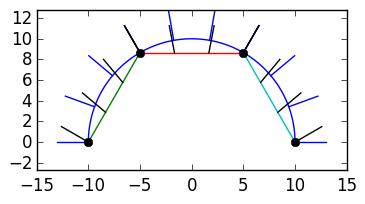

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2f88640750>

In [8]:
plot_stuff(elements)

**Strategy 2**: get some info about geometry, here we know that $x^2 + y^2 - 10^2 = 0$.

In [9]:
using JuliaFEM: interpolate
using ForwardDiff

function fix_normals_by_geometry(elements, geom_info, normal_field=:normals)
    g = ForwardDiff.gradient(geom_info)
    n(p) = g(p)/norm(g(p))
    for el in elements
        coords = interpolate(el, :geometry, Vector[[-1.0], [1.0]])
        normals = [n(p) for p in coords]
        set_field(el, normal_field, normals)
    end
end
fix_normals_by_geometry(elements, (X) -> X[1]^2 + X[2]^2 - 10^2)

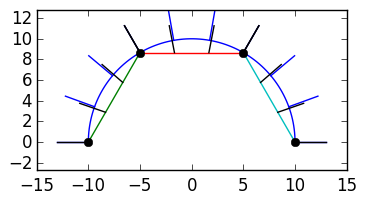

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2f88678750>

In [10]:
plot_stuff(elements)